# Colab Practice #3
In this lab, we are going to learn how to (1) detect ourliers, and (2) handle missing values. 

## Preparation

Currently, software installations within Colab is not persistent, in that you must reinstall libraries every time you (re-)connect to an instance. Let's install Plotly 4.1.0 (most recent version), which is not installed by default. 

In [ ]:
import os
import sys
from google.colab import drive

google_drive_prefix = '/content/drive'
drive.mount(google_drive_prefix) # Mount Google Drive

project_directory = '/content/drive/My Drive/EE5104 Datasets/'
sys.path.insert(0, project_directory) # add class folder to sys.path

Mounted at /content/drive


In [ ]:
!pip install plotly==4.1.1

     |████████████████████████████████| 7.1 MB 5.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=a9cd576d4aa73a4d81b00f3f3958ad2e227bd6d35d7b765ae65d784564939cce
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


We are goint to use the crowdsignal dataset. The below method returns magnetometer_phone data. Please note that due to the size of data, we will only first 500 rows (**out of 176,833 rows**). 

In [ ]:
import pandas as pd 

# define a method that first n rows of magnetometer_phone data from crowdsignal.io dataset.
# if no parameter (or input value) is set, it returns first 500 rows.

def get_simple_magnetometer_phone(size = 500):
  result = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/crowdsignals.io/magnetometer_phone.csv').sort_values(by=['timestamps'])[:size]
  result = result.drop(columns=['Unnamed: 6'])
  result = result.sort_values(by=['timestamps'])
  result.reset_index(inplace=True, drop=True)
  return result

## Outlier Detection

###  Distribution-Based Models

We will learn how to apply Chauvenet's Criterion to test outliers. 

**Normality test**

1. One assumption for applying Chauvenet's criterion is that the data follow a normal distribution. We are going to check whether crowdsignal data follow a normal distribution. For this, we are going to use [SciPy](https://www.scipy.org/).

In [ ]:
!pip install scipy

stats.normaltest(data) tests normality of input data.

In [ ]:
from scipy import stats
import numpy as np

def isNormallyDistributed(data, sig = 0.05):
  k2, p = stats.normaltest(data) # if p is smaller than 0.05, data is not normally distributed
  return p >= sig

In [ ]:
x = np.random.rand(20) # returns an array that has 20 random samples from a uniform distribution over [0, 1).
print(x)
print('M =%f, SD = %f'%(np.mean(x), np.std(x)))
print(isNormallyDistributed(x))

[0.42475046 0.59616162 0.37835902 0.83246285 0.45508925 0.22449851
 0.92609276 0.27237375 0.98603775 0.36396122 0.56290622 0.69181371
 0.87413586 0.2949461  0.20847295 0.08233621 0.17090732 0.90959864
 0.02631734 0.58043581]
M =0.493083, SD = 0.291070
True


In [ ]:
x = np.full(20, 10) # returns an array that has twenty 10
print(x)
print('M =%f, SD = %f'%(np.mean(x), np.std(x)))
print(isNormallyDistributed(x))

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
M =10.000000, SD = 0.000000
False


2. Let's do a normality test for crowdsignal data. It turned out it's not normally distributed. In this case, we need to visually inspect the distribution to see how the distribution looks like. In addition, we may want to think of different metrics such as median absolute difference (MAD) for outlier detection. Anyhow, normality assumption can be relaxed in outlier detection. But please do note that you need to check how the distribution looks like; and if necessary, please use alternative approaches such as MAD. 

*   Normality Assumption: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm 
*   MAD: Leys 2013, Detecting outliers: Do not use standard deviation around the mean, use absolute deviation around the median https://www.sciencedirect.com/science/article/pii/S0022103113000668 
 

In [ ]:
simple_magnetometer_phone = get_simple_magnetometer_phone() # Get first 500 rows from magnetometer_phone data 
x = simple_magnetometer_phone.x
print(x)
print('M =%f, SD = %f'%(np.mean(x), np.std(x)))
print(isNormallyDistributed(x))

0     -73.32
1     -73.38
2     -73.26
3     -73.20
4     -73.14
       ...  
495   -76.56
496   -76.56
497   -76.50
498   -76.50
499   -76.44
Name: x, Length: 500, dtype: float64
M =-76.510680, SD = 0.822605
False


**Chauvenet’s criterion**

[The chauvenet method](https://en.wikipedia.org/wiki/Chauvenet%27s_criterion) returns a list showing outlier (True = outlier).

In [ ]:
import math
import pandas as pd
import scipy
import numpy as np

def chauvenet(df):
    mean = df.mean()              # Mean of incoming array
    std = df.std()                # Standard deviation
    N = len(df)                   # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(df-mean)/std          # Distance of a value to mean in stdv's
    prob = scipy.special.erfc(d)  # Area normal dist.
    return prob < criterion       # Use boolean array outside this function

In [ ]:
chauvenet(simple_magnetometer_phone.x)

0       True
1       True
2       True
3       True
4       True
       ...  
495    False
496    False
497    False
498    False
499    False
Name: x, Length: 500, dtype: bool

In [ ]:
simple_magnetometer_phone['x_outlier'] = chauvenet(simple_magnetometer_phone.x) # create and add 'x_outlier' column that showing true if magnetometer_phone.x for a given row is outlier
print('overall # of rows', simple_magnetometer_phone.shape[0])
print('number of x_outlier: {}'.format(simple_magnetometer_phone.loc[simple_magnetometer_phone.x_outlier == True, ['x_outlier']].count()[0]))

overall # of rows 500
number of x_outlier: 33


In [ ]:
# see https://plotly.com/python/plotly-express/ for more express plots!
import plotly.express as px

fig = px.histogram(simple_magnetometer_phone, x="x")
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

fig = px.histogram(simple_magnetometer_phone, x="x", color="x_outlier") # showing different color depending on boolean value (TRUE or FALSE) in x_outliner column
fig.show()

**Mini exercise**: Try with first 600 rows of crowdsignal data. Draw two line graphs; one shows initial data. Anothere shows which are outliers (e.g., red dot), in addiiton to initial data. With the below code, you can get first 100 rows of crowdsignal data

In [ ]:
get_simple_magnetometer_phone(600)

,sensor_type,device_type,timestamps,x,y,z
0,magnetometer,smartphone,1454956105814006197,-73.32,-137.64,-28.68
1,magnetometer,smartphone,1454956105823843386,-73.38,-137.64,-28.62
2,magnetometer,smartphone,1454956105834447031,-73.26,-137.76,-28.74
3,magnetometer,smartphone,1454956105843433334,-73.20,-137.88,-28.86
4,magnetometer,smartphone,1454956105853464270,-73.14,-137.94,-28.98
...,...,...,...,...,...,...
595,magnetometer,smartphone,1454956111744804063,-76.56,-140.82,-28.92
596,magnetometer,smartphone,1454956111754769792,-76.56,-140.82,-28.92
597,magnetometer,smartphone,1454956111764907917,-76.62,-140.82,-28.86
598,magnetometer,smartphone,1454956111774915886,-76.62,-140.88,-28.86


### Distance-Based Models

####Simple Distance-Based Approach

The simple_distance_based_outlier_detection method returns the rows that are outliers.

In [ ]:
# understanding skipy pdist and squareform
# documentation here https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
import scipy

df = pd.DataFrame([[0,0], [1,1], [2,2]], columns=['x', 'y'])
print('df\n', df, end='\n\n')

dist = scipy.spatial.distance.pdist(df, 'euclidean')
print('dist\n', dist, end='\n\n')

sq = scipy.spatial.distance.squareform(dist)
print(sq)

df
    x  y
0  0  0
1  1  1
2  2  2

dist
 [1.41421356 2.82842712 1.41421356]

[[0.         1.41421356 2.82842712]
 [1.41421356 0.         1.41421356]
 [2.82842712 1.41421356 0.        ]]


In [ ]:
import scipy
import math
from sklearn import mixture
import numpy as np
import pandas as pd
import copy

def get_normalized(df):
  return (df - df.min()) / (df.max() - df.min())

def simple_distance_based_outlier_detection(df, min_distance, min_frequency):
  df_norm = df.copy() # Make a copy of df, which type is Pandas' Dataframe.
  df_norm = get_normalized(df_norm) # Normalize data
  pairwise_distance = scipy.spatial.distance.pdist(df_norm, 'euclidean') # Pairwise distances between observations in n-dimensional space.
  distance_matrix = scipy.spatial.distance.squareform(pairwise_distance) # Converts a vector-form distance vector to a square-form distance matrix, and vice-versa.
  distance_df = pd.DataFrame(distance_matrix, columns=df_norm.index, index = df_norm.index) 
  # Create new dataframe with distance_matrix that has df_norm.index as index, and each value in df_norm.index as the name of each column.
  # The output dataframe will look like the below table. Each value shows a distance. 
  # For example, the value in the second column of the first row (0.013699) shows the distance between first and second row in input df datatframe.
  #
  # index    
  #   ↓       0         1         2    ...       497       498       499  ← column names
  #   0  0.000000  0.013699  0.032445  ...  1.097869  1.097869  1.077779
  #   1  0.013699  0.000000  0.040195  ...  1.088859  1.088859  1.068775
  #   2  0.032445  0.040195  0.000000  ...  1.085273  1.085273  1.065175
  #   3  0.064891  0.071757  0.032445  ...  1.073510  1.073510  1.053420
  #   4  0.084234  0.091701  0.051932  ...  1.072836  1.072836  1.052761

  df_greater_than_min_dis = distance_df[distance_df > min_distance].count() 
  # For each row, count and return the number of columns which values are larger than input min_distance
  # The output will look like the below exmaple
  # 0      481
  # 1      481
  # 2      481
  # 3      480
  
  df_greater_than_min_frequency = df_greater_than_min_dis/len(df_greater_than_min_dis) > min_frequency
  # len(df_greater_than_min_dis) return the length of rows, which is same as the length of rows for the input df.
  # df_greater_than_min_dis/len(df_greater_than_min_dis) returns percentage of each value of df_greater_than_min_dis
  # df_greater_than_min_dis/len(df_greater_than_min_dis) > min_frequency returns true if the the percentage is larger than the input min_frequency
  df['outlier'] = df_greater_than_min_frequency # add df_greater_than_min_frequency as new column named 'outlier'
  return df

Before run the method, let's first see how the orginal data looks like

In [ ]:
import plotly.graph_objects as go
import pandas as pd

simple_magnetometer_phone = get_simple_magnetometer_phone()[['x','y']]
normalized_simple = get_normalized(simple_magnetometer_phone)

fig = go.Figure()
fig.add_trace(go.Scatter(y=normalized_simple.y, x=normalized_simple.x, mode='markers', name='x'))
fig.update_layout(autosize=False, width=800, height=800, margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),paper_bgcolor="LightSteelBlue")
fig.show()

Now, we run the code, and plot a similar graph but outliers are colored in red.

In [ ]:
import plotly.graph_objects as go
import pandas as pd

simple_magnetometer_phone = get_simple_magnetometer_phone()[['x','y']]
normalized_simple = get_normalized(simple_magnetometer_phone)

fig = go.Figure()
fig.add_trace(go.Scatter(y=normalized_simple.y, x=normalized_simple.x, mode='markers', name='x'))

min_distance = 0.5
min_frequency = 0.5
outliers = simple_distance_based_outlier_detection(normalized_simple, min_distance, min_frequency)
outliers = outliers[outliers.outlier == True]

fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, mode='markers', name='outlier'))
fig.update_layout(autosize=False, width=800, height=800, margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),paper_bgcolor="LightSteelBlue")
fig.show()

**Mini exercise**: Try how outliers for data change with different min_distance and min_frequency

In [ ]:
import plotly.graph_objects as go
import pandas as pd

simple_magnetometer_phone = get_simple_magnetometer_phone()[['x','y']]
normalized_simple = get_normalized(simple_magnetometer_phone)

fig = go.Figure()
fig.add_trace(go.Scatter(y=normalized_simple.y, x=normalized_simple.x, mode='markers', name='x'))

## 이부분 바꿔보기
min_distance = 0.5
min_frequency = 0.5
outliers = simple_distance_based_outlier_detection(normalized_simple, min_distance, min_frequency)
outliers = outliers[outliers.outlier == True]

fig.add_trace(go.Scatter(x=outliers.x, y=outliers.y, mode='markers', name='outlier'))
fig.update_layout(autosize=False, width=800, height=800, margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),paper_bgcolor="LightSteelBlue")
fig.show()

#### Local Outlier Factor

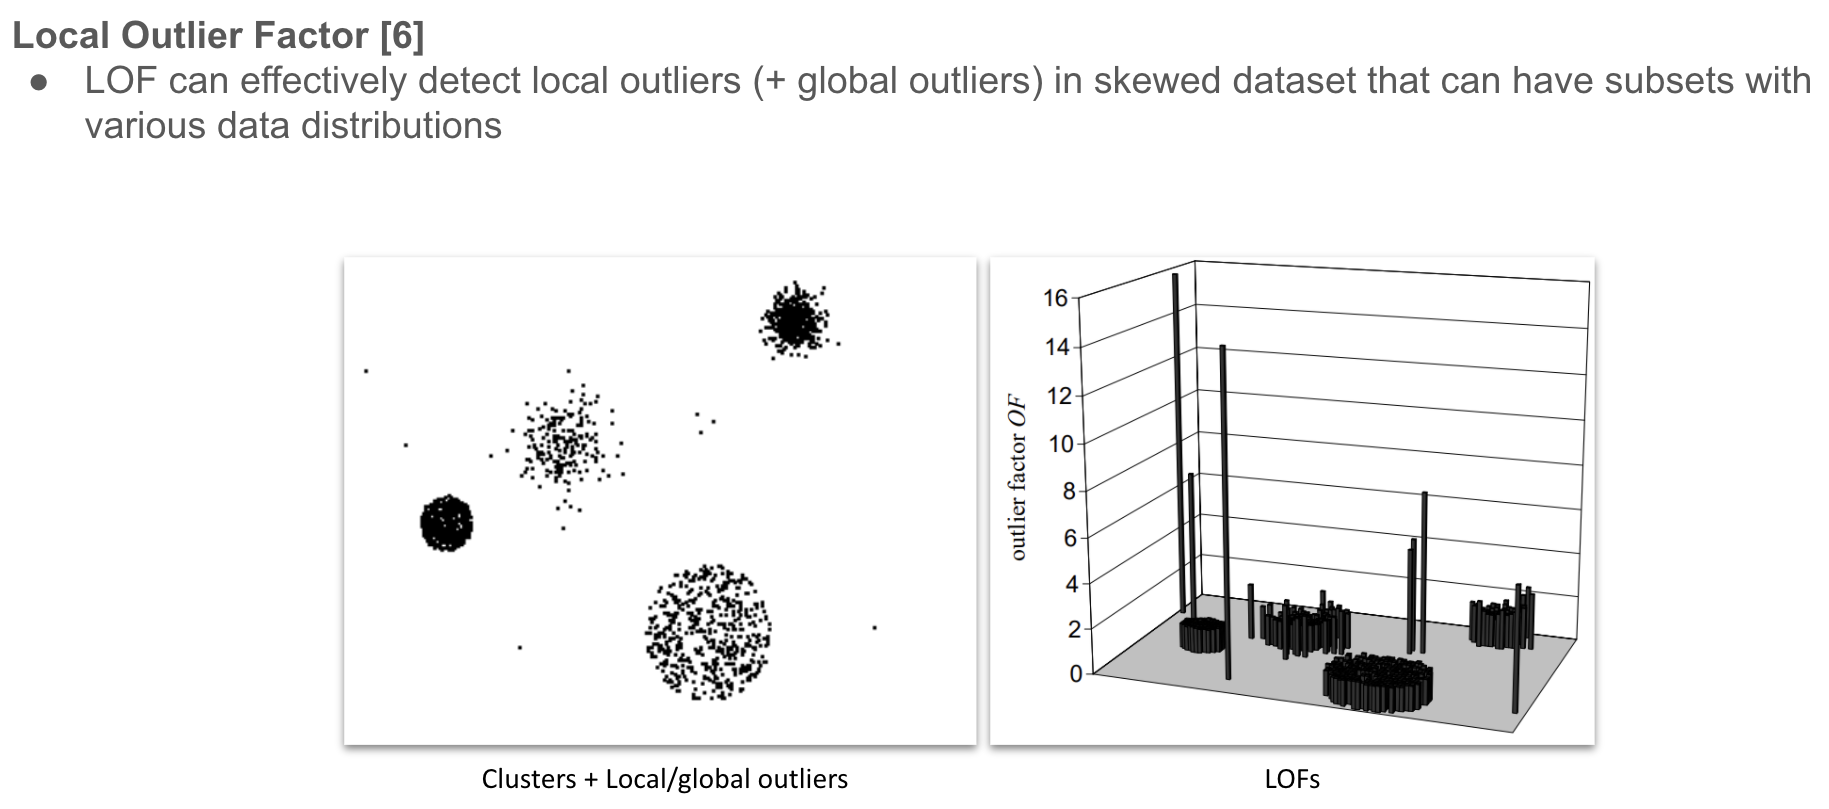

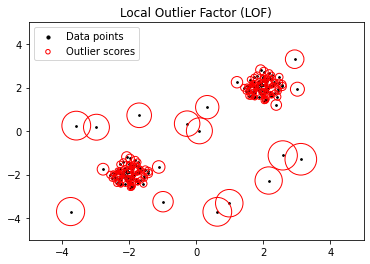

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

np.random.seed(42)

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

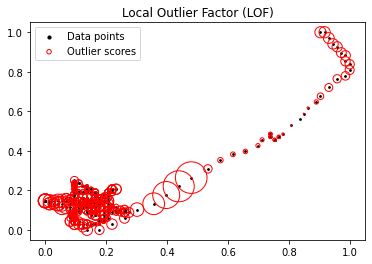

In [ ]:
X = get_normalized(get_simple_magnetometer_phone()[['x','y']])

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X.x, X.y, color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X.x, X.y, s=1000 * radius, edgecolors='r',facecolors='none', label='Outlier scores')
plt.axis('tight')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

## Imputation of Missing Values
 
Use a model-based approach to impute the heart rate. [*pandas.DataFrame.fillna*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) fills *NA/NaN* (NA/NaN (Not Available; Not a Number) values using the specified method. 

In [ ]:
import pandas as pd

 # Impute the mean values in case if missing data.
def impute_mean(dataset, col):
    dataset[col] = dataset[col].fillna(dataset[col].mean())
    return dataset

# Impute the median values in case if missing data.
def impute_median(dataset, col):
    dataset[col] = dataset[col].fillna(dataset[col].median())
    return dataset

# Interpolate the dataset based on previous/next values..
def impute_interpolate(dataset, col):
    dataset[col] = dataset[col].interpolate()
    # And fill the initial data points if needed:
    dataset[col] = dataset[col].fillna(method='bfill')
    return dataset

In [ ]:
def array_with_missing_value():
  # let's generate a 5x5 matrix where each cell is filled w/ a random number  
  x = np.random.rand(5,5)
  # we intentionally replace a cell (2, 2) with NaN 
  x[2][2] = np.NaN
  return pd.DataFrame(data=x, columns=list('ABCDE'))

In [ ]:
df = array_with_missing_value()
print('Original Dataframe')
print(df)
impute_mean(df, 'C')
print('---------------------------------------------------')
print('Imputed Dataframe')
print(df)

Original Dataframe
          A         B         C         D         E
0  0.726091  0.975852  0.516300  0.322956  0.795186
1  0.270832  0.438971  0.078456  0.025351  0.962648
2  0.835980  0.695974       NaN  0.173294  0.156437
3  0.250243  0.549227  0.714596  0.660197  0.279934
4  0.954865  0.737897  0.554354  0.611721  0.419600
---------------------------------------------------
Imputed Dataframe
          A         B         C         D         E
0  0.726091  0.975852  0.516300  0.322956  0.795186
1  0.270832  0.438971  0.078456  0.025351  0.962648
2  0.835980  0.695974  0.465927  0.173294  0.156437
3  0.250243  0.549227  0.714596  0.660197  0.279934
4  0.954865  0.737897  0.554354  0.611721  0.419600


**Mini exercise**: Try imputation for numeric columns in *window_250L* data. First apply impute_interpolate. Next, apply impute_mean. After done both imputations, save the data as *window_250L_\<imputation_method>.csv* (e.g., window_250L_impute_mean.csv). Before doing exercise, please see three hints.

Hint 1: You can load and save the data with the below code. 

In [ ]:
window_250L = pd.read_csv('/content/drive/My Drive/Sensor Data Science/output/window_250L.csv') # load data
window_250L.to_csv('/content/drive/My Drive/Sensor Data Science/output/window_250L_imputation.csv') # save data

window_250L[window_250L.phone_acc_x.isna()].count()

timestamps        78
phone_acc_x        0
phone_acc_y        0
phone_acc_z        0
watch_acc_x       78
watch_acc_y       78
watch_acc_z       78
old_timestamps    78
dtype: int64

Hint 2: You can count non-missing-value cells for each column.

In [ ]:
window_250L.count(axis = 0)

timestamps        7133
phone_acc_x       7055
phone_acc_y       7055
phone_acc_z       7055
watch_acc_x       7133
watch_acc_y       7133
watch_acc_z       7133
old_timestamps    7133
dtype: int64

Hint 3: You can check correctness of your answer with below method. The hasCorrectAnswer method prints "Good job!!!" when given df has no missing values.

In [ ]:
def hasCorrectAnswer(df):
  if df.shape[0] - df.dropna().shape[0]:
    print("Please try again.")
  else:
    print("Good job!!!")

# def hasCorrectAnswer(df):
#   df_row_length = len(df)
#   isCorrect = True
#   for count in df.count(axis = 0):
#     if df_row_length != count:
#       isCorrect = False
#   print("Good job!!!" if isCorrect else "Please try again.")

Exercise Answer:

## Kalman filter

Now we will play with the Kalman filter for smoothing (or outlier removal). Although the explanation of the Kalman filter in our book is quite mathematically involved, you can find an intuitive explanation here at http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ 

We will use '[pykalman](https://pykalman.github.io/)' library. This library is not available by default but you can download and install the library. To install, run the code below.   

In [ ]:
!pip install pykalman

     |████████████████████████████████| 228 kB 5.1 MB/s 
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48462 sha256=69e07ed02fbd238a50da2564a20f958081efc0592e9b3f823676745c96e62c38
  Stored in directory: /root/.cache/pip/wheels/6a/04/02/2dda6ea59c66d9e685affc8af3a31ad3a5d87b7311689efce6
Successfully built pykalman


In [ ]:
import numpy as np
from pykalman import KalmanFilter

df = get_simple_magnetometer_phone()

In [ ]:
# masking invalid values for kalman (fitting)

arr = np.array([1,2,3,4,5,np.nan,np.inf])
arr_msk = np.ma.masked_invalid(arr)
arr_msk

masked_array(data=[1.0, 2.0, 3.0, 4.0, 5.0, --, --],
             mask=[False, False, False, False, False,  True,  True],
       fill_value=1e+20)

In [ ]:
kf = KalmanFilter(transition_matrices = [[1]], observation_matrices = [[1]], initial_state_mean= df.loc[0,['x']])
numpy_array_state = df.x.values
numpy_array_state = numpy_array_state.astype(np.float32)
numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
kf = kf.em(numpy_matrix_state_with_mask, n_iter=5)
(new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)
df['x_kalman'] = new_data
df.head()

,sensor_type,device_type,timestamps,x,y,z,x_kalman
0,magnetometer,smartphone,1454956105814006197,-73.32,-137.64,-28.68,-73.321947
1,magnetometer,smartphone,1454956105823843386,-73.38,-137.64,-28.62,-73.359202
2,magnetometer,smartphone,1454956105834447031,-73.26,-137.76,-28.74,-73.292717
3,magnetometer,smartphone,1454956105843433334,-73.20,-137.88,-28.86,-73.230290
4,magnetometer,smartphone,1454956105853464270,-73.14,-137.94,-28.98,-73.169469


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(y=df.x, x=df.timestamps, mode='markers', name='x'))
fig.add_trace(go.Scatter(y=df.x_kalman, x=df.timestamps, mode='markers', name='x_kalman'))
fig.update_layout(autosize=False, width=800, height=800, margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),paper_bgcolor="LightSteelBlue")
fig.show()

This time, we use the Kalman filter to remove outlier for location data in crowdsignals.io.

In [ ]:
import numpy as np
import plotly.express as px
import pandas as pd

from pykalman import KalmanFilter

locations = pd.read_csv('/content/drive/My Drive/EE5104 Datasets/crowdsignals.io/location_phone.csv')
locations.drop(columns=['Unnamed: 6'], inplace=True)
locations.sort_values(by=['timestamps'], inplace=True)
locations.head()

,sensor_type,device_type,timestamps,latitude,longitude,speed
233,location,smartphone,1454956583486,47.546,-122.059,6.850
234,location,smartphone,1454956593465,47.546,-122.059,2.478
166,location,smartphone,1454957318561,47.546,-122.060,0.361
290,location,smartphone,1454957439584,47.546,-122.060,0.555
291,location,smartphone,1454957440545,47.546,-122.059,0.020


In [ ]:
cpy_timestamps = locations.timestamps.copy()
locations['cpy_timestamps'] = cpy_timestamps
locations.sort_values(by=['cpy_timestamps'], inplace=True)
locations.timestamps = pd.to_datetime(cpy_timestamps, unit='ms') 
locations.set_index('timestamps', drop=True, inplace=True)
print(locations.head())

                        sensor_type device_type  latitude  longitude  speed  \
timestamps                                                                    
2016-02-08 18:36:23.486    location  smartphone    47.546   -122.059  6.850   
2016-02-08 18:36:33.465    location  smartphone    47.546   -122.059  2.478   
2016-02-08 18:48:38.561    location  smartphone    47.546   -122.060  0.361   
2016-02-08 18:50:39.584    location  smartphone    47.546   -122.060  0.555   
2016-02-08 18:50:40.545    location  smartphone    47.546   -122.059  0.020   

                         cpy_timestamps  
timestamps                               
2016-02-08 18:36:23.486   1454956583486  
2016-02-08 18:36:33.465   1454956593465  
2016-02-08 18:48:38.561   1454957318561  
2016-02-08 18:50:39.584   1454957439584  
2016-02-08 18:50:40.545   1454957440545  


In [ ]:
measurements = locations[['latitude','longitude']].values

In [ ]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

kf1 = kf1.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

In [ ]:
locations['new_latitude'] = smoothed_state_means[:, 0]
locations['new_longitude'] = smoothed_state_means[:, 2]
print(locations[['latitude','longitude','new_latitude','new_longitude']][:30])

                         latitude  longitude  new_latitude  new_longitude
timestamps                                                               
2016-02-08 18:36:23.486    47.546   -122.059     47.546000    -122.058979
2016-02-08 18:36:33.465    47.546   -122.059     47.546000    -122.059200
2016-02-08 18:48:38.561    47.546   -122.060     47.546000    -122.059820
2016-02-08 18:50:39.584    47.546   -122.060     47.546000    -122.059815
2016-02-08 18:50:40.545    47.546   -122.059     47.546000    -122.059192
2016-02-08 18:50:41.545    47.546   -122.059     47.546000    -122.059009
2016-02-08 18:50:42.541    47.546   -122.059     47.546000    -122.058973
2016-02-08 18:50:43.542    47.546   -122.059     47.546000    -122.059000
2016-02-08 18:54:03.569    47.546   -122.059     47.546000    -122.059175
2016-02-08 18:59:06.611    47.546   -122.060     47.546000    -122.059820
2016-02-08 18:59:17.000    47.546   -122.060     47.546000    -122.059992
2016-02-08 18:59:18.000    47.546   -1

In [ ]:
import plotly.express as px

fig = go.Figure()

fig.add_trace(go.Scattermapbox(
    name='observation',
    lat=locations['latitude'],
    lon=locations['longitude'],mode='markers',
    marker=go.scattermapbox.Marker(
            size=5,
            color='blue',
            opacity=0.3
        )
    ))

fig.add_trace(go.Scattermapbox(
        name='kalman_smoother',
        lat=locations['new_latitude'],
        lon=locations['new_longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=5,
            color='red',
            opacity=0.3
        )
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken='pk.eyJ1Ijoia2ltYXVrIiwiYSI6ImNqMWMxYnFvMzBhc3Ayd3FzOXpyNjE3OHEifQ.4j_gWkOllgcl67tg3W5Rcw',
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=locations['latitude'][0],
            lon=locations['longitude'][0]
        ),
        zoom=10
    )
)

fig.show()

# Homework #3: Preprocessing KAIST dataset

Homework #3 is due on **9/28 (Monday) at 23:59:59**. Submit your Jupyter notebook via Google Classroom. Note that you do not need to submit (or upload) any output files. If you get memory error, please shorten size of data (e.g., use first 1000 rows). 

**Q1.** Please (1) apply chauvenet outlier detection method for heart rate data from KAIST dataset and (2) plot a graph with the outliers in red, similar to we did.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

# read csv
import os
dataset_directory = '/content/drive/My Drive/EE5104 Datasets/K-EmoPhone/kemophone/P0702/'

import pandas as pd
from os.path import join
heart_rate = pd.read_csv(join(dataset_directory, 'HeartRate.csv'))
heart_rate.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,timestamp,BPM,Quality
0,1557798584487,70,ACQUIRING
1,1557798585483,70,ACQUIRING
2,1557798586483,70,ACQUIRING
3,1557798587487,70,ACQUIRING
4,1557798588472,70,ACQUIRING


In [19]:
!pip install scipy

In [20]:
from scipy import stats
import numpy as np

def isNormallyDistributed(data, sig = 0.05):
  k2, p = stats.normaltest(data) # if p is smaller than 0.05, data is not normally distributed
  return p >= sig

def get_simple_heart_rate(size = 1000):
  result = pd.read_csv(join(dataset_directory, 'HeartRate.csv')).sort_values(by=['timestamp'])[:size]
  result = result.sort_values(by=['timestamp'])
  result.reset_index(inplace=True, drop=True)
  return result

simple_heart_rate = get_simple_heart_rate()
x = simple_heart_rate.BPM
print(x)
print('M =%f, SD = %f'%(np.mean(x), np.std(x)))
print(isNormallyDistributed(x))

0      66
1      66
2      66
3      66
4      66
       ..
995    84
996    84
997    84
998    84
999    84
Name: BPM, Length: 1000, dtype: int64
M =73.484000, SD = 3.059043
False


In [21]:
import math
import pandas as pd
import scipy
import numpy as np

def chauvenet(df):
    mean = df.mean()              # Mean of incoming array
    std = df.std()                # Standard deviation
    N = len(df)                   # Lenght of incoming array
    criterion = 1.0/(2*N)         # Chauvenet's criterion
    d = abs(df-mean)/std          # Distance of a value to mean in stdv's
    prob = scipy.special.erfc(d)  # Area normal dist.
    return prob < criterion       # Use boolean array outside this function

chauvenet(simple_heart_rate.BPM)

0      False
1      False
2      False
3      False
4      False
       ...  
995     True
996     True
997     True
998     True
999     True
Name: BPM, Length: 1000, dtype: bool

In [22]:
simple_heart_rate['BPM_outlier'] = chauvenet(simple_heart_rate.BPM)
print('overall # of rows', simple_heart_rate.shape[0])
print('number of BPM_outlier: {}'.format(simple_heart_rate.loc[simple_heart_rate.BPM_outlier == True, ['BPM_outlier']].count()[0]))

overall # of rows 1000
number of BPM_outlier: 11


In [23]:
import plotly.express as px
import pandas as pd

fig = px.histogram(simple_heart_rate, x="BPM", color="BPM_outlier") # showing different color depending on boolean value (TRUE or FALSE) in x_outliner column
fig.show()

**Q2.** Please remove outliers by applying simple distance-based outlier detection method for GSR data (timestamp and resistance) from KAIST dataset. 

In [26]:
# read csv
import os
dataset_directory = '/content/drive/My Drive/EE5104 Datasets/K-EmoPhone/kemophone/P0702/'

import pandas as pd
from os.path import join
gsr = pd.read_csv(join(dataset_directory, 'Gsr.csv'))
print(gsr.head())

def get_simple_gsr(size = 1000):
  result = pd.read_csv(join(dataset_directory, 'Gsr.csv')).sort_values(by=['timestamp'])[:size]
  result = result.sort_values(by=['timestamp'])
  result.reset_index(inplace=True, drop=True)
  return result

       timestamp  Resistance
0  1557365426562      340330
1  1557365426758      340330
2  1557365426971      340330
3  1557365427172      340330
4  1557365427372      340330


In [38]:
import scipy
import math
from sklearn import mixture
import numpy as np
import pandas as pd
import copy

def get_normalized(df):
  return (df - df.min()) / (df.max() - df.min())

def simple_distance_based_outlier_detection(df, min_distance, min_frequency):
  df_norm = df.copy() 
  df_norm = get_normalized(df_norm) 
  pairwise_distance = scipy.spatial.distance.pdist(df_norm, 'euclidean')
  distance_matrix = scipy.spatial.distance.squareform(pairwise_distance) 
  distance_df = pd.DataFrame(distance_matrix, columns=df_norm.index, index = df_norm.index) 

  df_greater_than_min_dis = distance_df[distance_df > min_distance].count() 
  df_greater_than_min_frequency = df_greater_than_min_dis/len(df_greater_than_min_dis) > min_frequency
  df['outlier'] = df_greater_than_min_frequency # add df_greater_than_min_frequency as new column named 'outlier'
  return df


import plotly.graph_objects as go

simple_gsr = get_simple_gsr()
normalized_simple = get_normalized(simple_gsr)

fig = go.Figure()
min_distance = 0.5
min_frequency = 0.5
outliers = simple_distance_based_outlier_detection(normalized_simple, min_distance, min_frequency)
outliers = outliers[outliers.outlier == True]

# I removed outlier through removing data which is "normalized_simple.outlier == True"
remove_outlier = normalized_simple[normalized_simple.outlier == False]
fig.add_trace(go.Scatter(y=remove_outlier.Resistance, x=remove_outlier.timestamp, mode='markers', name='Gsr'))
fig.update_layout(autosize=False, width=800, height=800, margin=go.layout.Margin(l=50, r=50, b=50, t=50, pad=4),paper_bgcolor="LightSteelBlue")
fig.show()

**Q3.** Please (1) apply mean imputation method for 'KAIST_250L.csv' in your output folder and (2) save the output as 'KAIST_250L_imputation.csv'. If you have finished HW#2, then you have 'KAIST_250L.csv' in your output folder.

* There's no NaN data in KAIST_250L data, so I made KAIST_20L data from same dataset and used it.

In [51]:
import pandas as pd

 # Impute the mean values in case if missing data.
def impute_mean(dataset, col):
    dataset[col] = dataset[col].fillna(dataset[col].mean())
    return dataset

# Impute the median values in case if missing data.
def impute_median(dataset, col):
    dataset[col] = dataset[col].fillna(dataset[col].median())
    return dataset

# Interpolate the dataset based on previous/next values..
def impute_interpolate(dataset, col):
    dataset[col] = dataset[col].interpolate()
    # And fill the initial data points if needed:
    dataset[col] = dataset[col].fillna(method='bfill')
    return dataset

In [52]:
# read csv
import os
import pandas as pd
from os.path import join
output_directory = '/content/drive/My Drive/Sensor Data Science/output'
KAIST_20L = pd.read_csv(join(output_directory, 'KAIST_20L.csv'))
KAIST_20L = KAIST_20L.drop(columns=['old_timestamps'])
print(KAIST_20L.head(10))

                timestamps        BPM     acc_y     acc_x     acc_z
0  1970-01-01 00:25:57.260  74.572718  0.564624  0.013147  0.235607
1  1970-01-01 00:25:57.280  75.206385  0.625922 -0.038535  0.222160
2  1970-01-01 00:25:57.300  76.372120  0.194112  0.305889  0.213565
3  1970-01-01 00:25:57.320  66.900693  0.236623 -0.355160  0.627847
4  1970-01-01 00:25:57.340        NaN       NaN       NaN       NaN
5  1970-01-01 00:25:57.360  74.869544  0.540524  0.036410  0.297837
6  1970-01-01 00:25:57.380  82.171012  0.407189 -0.410568  0.371724
7  1970-01-01 00:25:57.400  69.487344  0.470101 -0.276329  0.461676
8  1970-01-01 00:25:57.420        NaN       NaN       NaN       NaN
9  1970-01-01 00:25:57.440  78.064567  0.557088 -0.318942  0.050244


In [53]:
impute_mean(KAIST_20L, 'BPM')
impute_mean(KAIST_20L, 'acc_y')
impute_mean(KAIST_20L, 'acc_x')
impute_mean(KAIST_20L, 'acc_z')
KAIST_20L

,timestamps,BPM,acc_y,acc_x,acc_z
0,1970-01-01 00:25:57.260,74.572718,0.564624,0.013147,0.235607
1,1970-01-01 00:25:57.280,75.206385,0.625922,-0.038535,0.222160
2,1970-01-01 00:25:57.300,76.372120,0.194112,0.305889,0.213565
3,1970-01-01 00:25:57.320,66.900693,0.236623,-0.355160,0.627847
4,1970-01-01 00:25:57.340,77.331381,0.209265,0.040177,0.096780
5,1970-01-01 00:25:57.360,74.869544,0.540524,0.036410,0.297837
6,1970-01-01 00:25:57.380,82.171012,0.407189,-0.410568,0.371724
7,1970-01-01 00:25:57.400,69.487344,0.470101,-0.276329,0.461676
8,1970-01-01 00:25:57.420,77.331381,0.209265,0.040177,0.096780
9,1970-01-01 00:25:57.440,78.064567,0.557088,-0.318942,0.050244


In [54]:
KAIST_20L.to_csv('/content/drive/My Drive/Sensor Data Science/output/KAIST_20L_imputation.csv') # save data
